In [1]:
import pandas as pd
import subprocess
import os
from google.cloud import storage
import subprocess
import re
import rasterio
import osmnx as ox
import rasterio.features
from rasterio.plot import show
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import numpy as np

In [8]:
landsat8 = pd.read_csv('./LANDSAT_8_C1_281917.csv', encoding = "ISO-8859-1", parse_dates=['Acquisition Date'])
landsat8["Acquisition Date"] = pd.to_datetime(landsat8['Acquisition Date'].dt.strftime("%Y%m%d"))

In [28]:
landsat8.shape

(256, 70)

In [29]:
landsat8 = landsat8[(landsat8['WRS Path'] == 165) | (landsat8['WRS Path'] == 166)]

In [30]:
count = 0
for idx, i in landsat8.iterrows():
    if idx % 2 == 0 and i['WRS Path'] == 166:
        count +=1

In [31]:
count

77

In [32]:
landsat8.shape

(251, 70)

In [33]:
landsat8.sort_values(by='Acquisition Date', inplace=True)
landsat8.reset_index(inplace=True)
landsat8.rename(mapper={"Acquisition Date": "date"}, axis=1, inplace=True)

/home/nawafalsane/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/nawafalsane/.local/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [37]:
landsat8_gs = pd.DataFrame(columns=['area', 'date', 'b', 'gs_location'])

In [38]:
land8_lst = []
with open('landsat8.txt', 'r') as file:
    for line in file:
        rex = re.compile(r'.TIF')
        if rex.search(line) != None:
            land8_lst.append(line)
land8_lst[:5]

['gs://gcp-public-data-landsat/LC08/01/165/043/LC08_L1TP_165043_20130404_20170505_01_T1/LC08_L1TP_165043_20130404_20170505_01_T1_B1.TIF\n',
 'gs://gcp-public-data-landsat/LC08/01/165/043/LC08_L1TP_165043_20130404_20170505_01_T1/LC08_L1TP_165043_20130404_20170505_01_T1_B10.TIF\n',
 'gs://gcp-public-data-landsat/LC08/01/165/043/LC08_L1TP_165043_20130404_20170505_01_T1/LC08_L1TP_165043_20130404_20170505_01_T1_B11.TIF\n',
 'gs://gcp-public-data-landsat/LC08/01/165/043/LC08_L1TP_165043_20130404_20170505_01_T1/LC08_L1TP_165043_20130404_20170505_01_T1_B2.TIF\n',
 'gs://gcp-public-data-landsat/LC08/01/165/043/LC08_L1TP_165043_20130404_20170505_01_T1/LC08_L1TP_165043_20130404_20170505_01_T1_B3.TIF\n']

In [39]:
for idx, line in enumerate(land8_lst):
    dic = {}
    spl = line.split("_")
    dic["area"] = spl[2][:3]
    dic["date"] = spl[3]
    dic["b"] = spl[-1].split(".")[0]
    dic["gs_location"] = line
    landsat8_gs.loc[idx] = dic

In [40]:
landsat8_gs.shape

(3997, 4)

In [41]:
landsat8_gs = landsat8_gs[(landsat8_gs.b == 'B4') | (landsat8_gs.b == 'B3')]
landsat8_gs.reset_index(inplace=True)
landsat8_gs["date"] = pd.to_datetime(landsat8_gs["date"])

In [42]:
landsat8_gs.dtypes

index                   int64
area                   object
date           datetime64[ns]
b                      object
gs_location            object
dtype: object

In [43]:
landsat8_merged = landsat8_gs.merge(landsat8, on="date")

In [44]:
landsat8_merged

,index_x,area,date,b,gs_location,index_y,Landsat Product Identifier,Landsat Scene Identifier,Collection Category,Collection Number,...,UL Corner Long dec,UR Corner Lat dec,UR Corner Long dec,LL Corner Lat dec,LL Corner Long dec,LR Corner Lat dec,LR Corner Long dec,Display ID,Ordering ID,Browse Link
0,4,165,2013-04-04,B3,gs://gcp-public-data-landsat/LC08/01/165/043/L...,253,LC08_L1TP_165043_20130404_20170505_01_T1,LC81650432013094LGN02,T1,1,...,46.63360,25.17832,48.42998,23.91751,46.25025,23.55329,48.02332,LC08_L1TP_165043_20130404_20170505_01_T1,LC81650432013094LGN02,https://earthexplorer.usgs.gov/browse-link/128...
1,5,165,2013-04-04,B4,gs://gcp-public-data-landsat/LC08/01/165/043/L...,253,LC08_L1TP_165043_20130404_20170505_01_T1,LC81650432013094LGN02,T1,1,...,46.63360,25.17832,48.42998,23.91751,46.25025,23.55329,48.02332,LC08_L1TP_165043_20130404_20170505_01_T1,LC81650432013094LGN02,https://earthexplorer.usgs.gov/browse-link/128...
2,16,165,2013-04-09,B3,gs://gcp-public-data-landsat/LC08/01/165/043/L...,252,LC08_L1TP_165043_20130409_20180301_01_T1,LC81650432013099LGN03,T1,1,...,46.81982,25.16899,48.65575,23.92722,46.43866,23.55449,48.25131,LC08_L1TP_165043_20130409_20180301_01_T1,LC81650432013099LGN03,https://earthexplorer.usgs.gov/browse-link/128...
3,17,165,2013-04-09,B4,gs://gcp-public-data-landsat/LC08/01/165/043/L...,252,LC08_L1TP_165043_20130409_20180301_01_T1,LC81650432013099LGN03,T1,1,...,46.81982,25.16899,48.65575,23.92722,46.43866,23.55449,48.25131,LC08_L1TP_165043_20130409_20180301_01_T1,LC81650432013099LGN03,https://earthexplorer.usgs.gov/browse-link/128...
4,28,165,2013-04-09,B3,gs://gcp-public-data-landsat/LC08/01/165/043/L...,252,LC08_L1TP_165043_20130409_20180301_01_T1,LC81650432013099LGN03,T1,1,...,46.81982,25.16899,48.65575,23.92722,46.43866,23.55449,48.25131,LC08_L1TP_165043_20130409_20180301_01_T1,LC81650432013099LGN03,https://earthexplorer.usgs.gov/browse-link/128...
5,29,165,2013-04-09,B4,gs://gcp-public-data-landsat/LC08/01/165/043/L...,252,LC08_L1TP_165043_20130409_20180301_01_T1,LC81650432013099LGN03,T1,1,...,46.81982,25.16899,48.65575,23.92722,46.43866,23.55449,48.25131,LC08_L1TP_165043_20130409_20180301_01_T1,LC81650432013099LGN03,https://earthexplorer.usgs.gov/browse-link/128...
6,40,165,2013-04-16,B3,gs://gcp-public-data-landsat/LC08/01/165/043/L...,251,LC08_L1TP_165043_20130416_20180605_01_T1,LC81650432013106LGN03,T1,1,...,46.75481,25.16679,48.60232,23.92903,46.37510,23.55463,48.19873,LC08_L1TP_165043_20130416_20180605_01_T1,LC81650432013106LGN03,https://earthexplorer.usgs.gov/browse-link/128...
7,41,165,2013-04-16,B4,gs://gcp-public-data-landsat/LC08/01/165/043/L...,251,LC08_L1TP_165043_20130416_20180605_01_T1,LC81650432013106LGN03,T1,1,...,46.75481,25.16679,48.60232,23.92903,46.37510,23.55463,48.19873,LC08_L1TP_165043_20130416_20180605_01_T1,LC81650432013106LGN03,https://earthexplorer.usgs.gov/browse-link/128...
8,52,165,2013-04-16,B3,gs://gcp-public-data-landsat/LC08/01/165/043/L...,251,LC08_L1TP_165043_20130416_20180605_01_T1,LC81650432013106LGN03,T1,1,...,46.75481,25.16679,48.60232,23.92903,46.37510,23.55463,48.19873,LC08_L1TP_165043_20130416_20180605_01_T1,LC81650432013106LGN03,https://earthexplorer.usgs.gov/browse-link/128...
9,53,165,2013-04-16,B4,gs://gcp-public-data-landsat/LC08/01/165/043/L...,251,LC08_L1TP_165043_20130416_20180605_01_T1,LC81650432013106LGN03,T1,1,...,46.75481,25.16679,48.60232,23.92903,46.37510,23.55463,48.19873,LC08_L1TP_165043_20130416_20180605_01_T1,LC81650432013106LGN03,https://earthexplorer.usgs.gov/browse-link/128...


In [45]:
landsat8_merged.shape

(666, 75)

In [16]:
landsat8_merged.isnull().sum().sum()

0

In [49]:
landsat8_merged.gs_location = landsat8_merged.gs_location.str.replace("\n", "")

In [54]:
with open('landsat8_link.txt', 'w') as f:
    for item in landsat8_merged.gs_location:
        f.write("%s\n" % item)

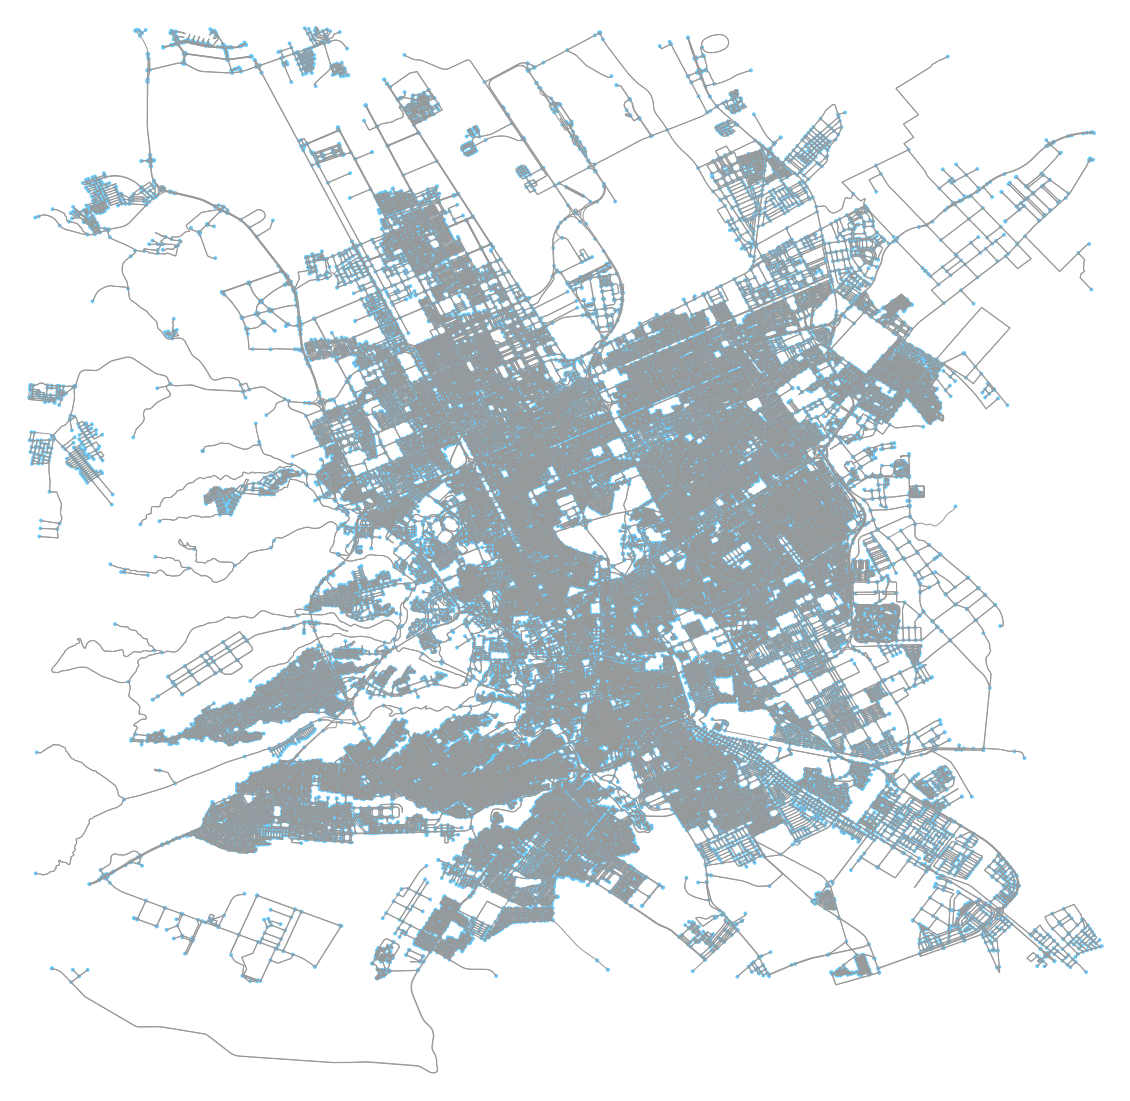

(<Figure size 1440x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe190a0bf98>)

In [3]:
riyadh = ox.graph_from_point((24.7387, 46.6994), distance=30000, network_type='drive')
G_projected = ox.project_graph(riyadh)
ox.plot_graph(G_projected, fig_height=20, fig_width=20)

In [4]:
nodes, edges = ox.graph_to_gdfs(riyadh)

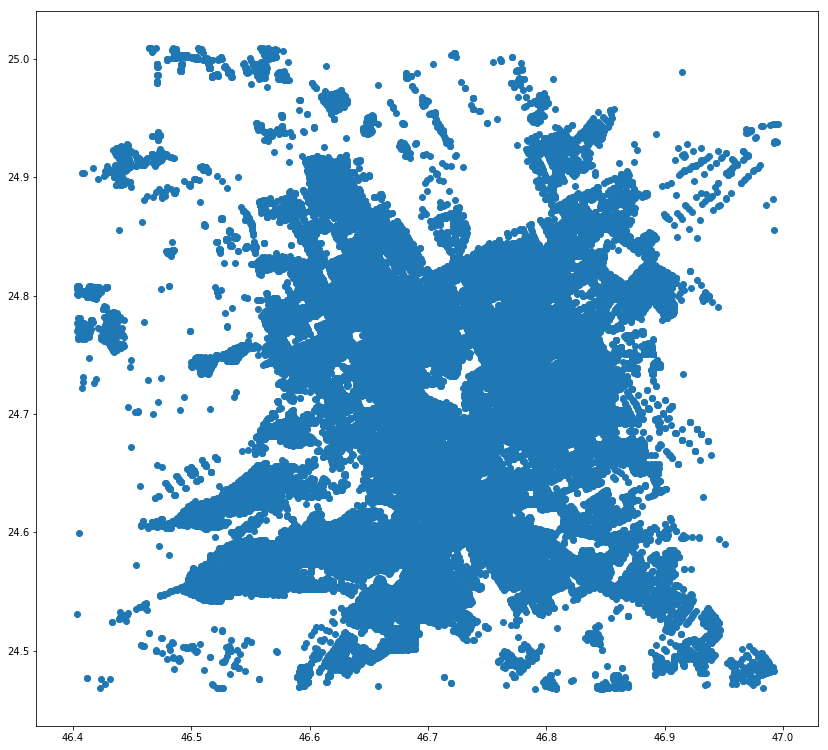

In [35]:
nodes.plot()

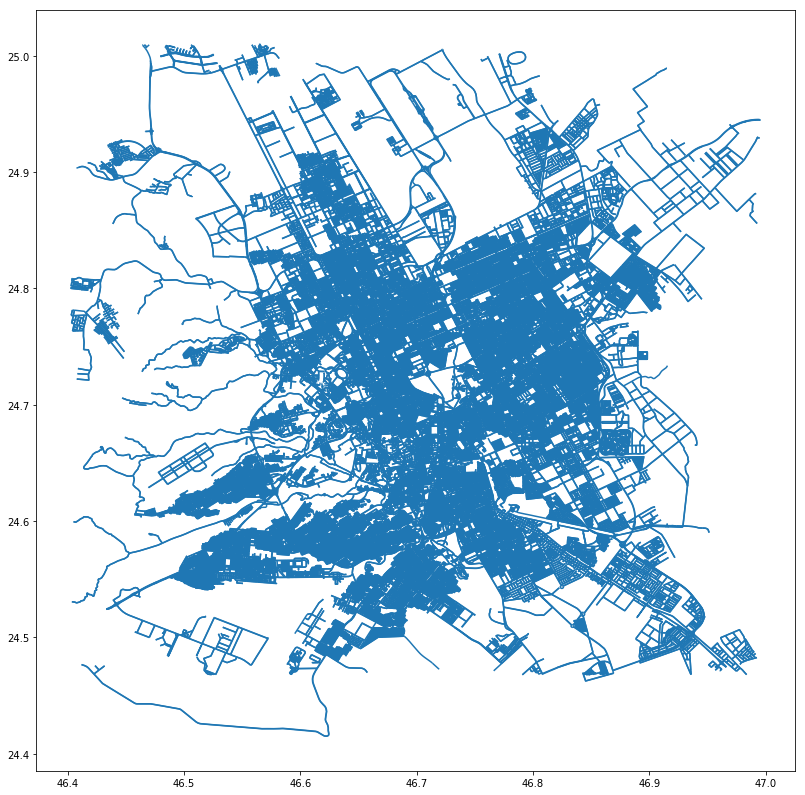

In [36]:
edges.plot()

In [3]:
merged = rasterio.open('./Other_stuff/merged2.TIF')

In [4]:
riyadh_merged = merged.read(1)

In [5]:
rasterizado = rasterio.features.rasterize(
    [(x.geometry, 1) for i, x in edges.iterrows()],
    out_shape=merged.shape,
    transform=merged.transform,
    fill=0,
    all_touched=True,
    dtype=rasterio.uint8, )


NameError: name 'edges' is not defined

In [ ]:
profile =merged.profile
profile.update(
    dtype=rasterio.uint8,
    count=1,
    compress='lzw', 
    nodata=0)
rasterizado[rasterizado < 1] = 0
with rasterio.open("./Other_stuff/RiyadhRoads.tif", 'w', **profile) as out:
    out.write_band(1, rasterizado)

In [ ]:
riyadh_raster = rasterio.open("./Other_stuff/RiyadhRoads.tif", 'r')
roads = riyadh_raster.read()

In [ ]:
roads_filtered = ndi.maximum_filter(roads, size= 5 )

In [ ]:
troads_access_osm = riyadh_merged[0] * roads_filtered[0]

plt.rcParams['figure.figsize'] = 14, 14
plt.imshow(np.log10((np.fmax( roads+1, 1))), vmin = 0, interpolation="bilinear")
bar = plt.colorbar(fraction=0.03)
bar.set_ticks([0, 0.301, 1.041, 1.708, 2.0043])
bar.set_ticklabels([0, 1, 10, 50, 100])